In [247]:
# Import utility functions
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import requests
import json
sys.path.append('..')  # Add parent directory to path

# Import from local utility modules
from lvt_utils import (model_split_rate_tax, calculate_current_tax, ensure_geodataframe, 
                       categorize_property_type, calculate_category_tax_summary, print_category_tax_summary)
from census_utils import (get_census_data_with_boundaries, match_parcels_to_demographics, 
                          create_demographic_summary, calculate_median_percentage_by_quintile, match_to_census_blockgroups)
from viz import (create_scatter_plot, plot_comparison, calculate_correlations, weighted_median, 
                 create_quintile_summary, plot_quintile_analysis, create_property_category_chart, 
                 create_map_visualization, calculate_block_group_summary, filter_data_for_analysis)

# Control variable for data scraping
data_scrape = 0  # Set to 1 to scrape new data, 0 to use existing data

print("✅ Utility functions imported from LVTShift modules")


✅ Utility functions imported from LVTShift modules


In [248]:
import glob
from datetime import datetime

# Create data directory if it doesn't exist
data_dir = "data/syracuse/"
os.makedirs(data_dir, exist_ok=True)

if data_scrape == 1:
    print("🔄 Scraping fresh Syracuse property data...")

    # Define the URL for the feature service (Syracuse Tax Parcels)
    base_url = "https://services.arcgis.com/uDTUpUPbk8X8mXwl/ArcGIS/rest/services/Syracuse_Tax_Parcels/FeatureServer/0/query"

    # Parameters for the query
    params = {
        'where': '1=1',  # Get all features
        'outFields': '*',  # Get all fields
        'returnGeometry': 'true',
        'f': 'geojson',  # Request GeoJSON format
        'resultRecordCount': 1000,  # Set a high limit for each page
        'resultOffset': 0  # Start at the beginning
    }

    # Initialize an empty list to store all features
    all_features = []

    print("📥 Downloading Syracuse parcel data...")
    while True:
        # Make the request
        response = requests.get(base_url, params=params)
        geojson_data = response.json()

        # Append the features from this page to the list
        features = geojson_data.get('features', [])
        all_features.extend(features)

        print(f"   Downloaded {len(all_features):,} parcels so far...")

        # Check if there are more features to fetch
        if len(features) < params['resultRecordCount']:
            break  # No more features to fetch

        # Update the offset for the next page
        params['resultOffset'] += params['resultRecordCount']

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(all_features)

    print(f"✅ Downloaded {len(gdf):,} Syracuse parcels")
    print(f"   Columns: {len(gdf.columns)}")

    # Calculate property taxes using Syracuse's millage rate
    millage_rate = 9.2645 / 1000  # Convert to decimal (per dollar)
    gdf['property_tax'] = gdf['CityTaxabl'] * millage_rate

    # Calculate improvement value and exemptions
    gdf['improvement_value'] = gdf['Fvalue'] - gdf['Lvalue']
    gdf['exemptions'] = gdf['Fvalue'] - gdf['CityTaxabl']

    # Calculate taxable values for split-rate analysis
    gdf['improvement_taxable'] = (gdf['improvement_value'] - gdf['exemptions']).clip(lower=0)
    gdf['land_taxable'] = gdf['CityTaxabl'] - gdf['improvement_taxable']

    # Calculate current total revenue
    target_revenue = gdf['property_tax'].sum()

    # Calculate split-rate tax (4:1 ratio) - following 00-pull-data.ipynb approach
    total_land_base = gdf['land_taxable'].sum()
    total_improvement_base = gdf['improvement_taxable'].sum()

    # Solve for improvement millage rate (land will be 4x this)
    improvement_rate = target_revenue / (4 * total_land_base + total_improvement_base)
    land_rate = 4 * improvement_rate

    # Calculate split rate taxes
    gdf['land_tax'] = gdf['land_taxable'] * land_rate
    gdf['improvement_tax'] = gdf['improvement_taxable'] * improvement_rate
    gdf['total_split_tax'] = gdf['land_tax'] + gdf['improvement_tax']

    # Calculate tax changes
    gdf['tax_change'] = gdf['total_split_tax'] - gdf['property_tax']
    gdf['tax_change_pct'] = (gdf['tax_change'] / gdf['property_tax']) * 100

    # Add land price per square foot
    gdf['land_price_per_sqft'] = gdf['land_taxable'] / gdf['Shape_Area']

    # Save the processed data with today's date in the filename
    today_str = datetime.now().strftime("%Y%m%d")
    save_path = f"{data_dir}syracuse_parcels_processed_{today_str}.parquet"
    gdf.to_parquet(save_path)
    print(f"💾 Saved processed data to {save_path}")

else:
    print("📂 Loading existing Syracuse property data...")
    # Find all processed parquet files in the data_dir
    parquet_files = glob.glob(os.path.join(data_dir, "syracuse_parcels_processed_*.parquet"))
    if not parquet_files:
        print("❌ No processed Syracuse data files found in data/syracuse/. Please set data_scrape = 1 to download fresh data.")
        raise FileNotFoundError("No processed Syracuse data files found.")
    # Extract dates and find the most recent file
    def extract_date(f):
        try:
            return datetime.strptime(os.path.basename(f).split("_")[-1].replace(".parquet", ""), "%Y%m%d")
        except Exception:
            return datetime.min
    parquet_files_sorted = sorted(parquet_files, key=extract_date, reverse=True)
    most_recent_file = parquet_files_sorted[0]
    gdf = gpd.read_parquet(most_recent_file)
    print(f"✅ Loaded processed Syracuse data from {most_recent_file}")

print(f"\n📊 Dataset Overview:")
print(f"Total parcels: {len(gdf):,}")
print(f"Columns: {len(gdf.columns)}")
print(f"Geometry type: {gdf.geometry.geom_type.iloc[0]}")

# Display key statistics
total_current_revenue = gdf['property_tax'].sum()
print(f"\n💰 Current Tax System:")
print(f"Total annual revenue: ${total_current_revenue:,.2f}")
print(f"Mean property tax: ${gdf['property_tax'].mean():,.2f}")
print(f"Median property tax: ${gdf['property_tax'].median():.2f}")


📂 Loading existing Syracuse property data...
✅ Loaded processed Syracuse data from data/syracuse/syracuse_parcels_processed_20250930.parquet

📊 Dataset Overview:
Total parcels: 41,697
Columns: 56
Geometry type: Polygon

💰 Current Tax System:
Total annual revenue: $31,644,825.77
Mean property tax: $758.92
Median property tax: $529.93


In [249]:
# Ensure proper GeoDataFrame format
gdf = ensure_geodataframe(gdf)

# Create vacant flag based on LandUse
gdf['is_vacant'] = gdf['LandUse'] == "Vacant Land"

# Apply standardized property categorization
gdf['PROPERTY_CATEGORY'] = gdf['LandUse']
# Display property statistics
print(f"🏠 Property Statistics:")
print(f"Total parcels: {len(gdf):,}")
print(f"Vacant parcels: {gdf['is_vacant'].sum():,} ({gdf['is_vacant'].sum()/len(gdf)*100:.1f}%)")

print("\\n📋 Property Categories (Standardized):")
category_counts = gdf['PROPERTY_CATEGORY'].value_counts()
for category, count in category_counts.head(10).items():
    pct = count / len(gdf) * 100
    print(f"  {category}: {count:,} ({pct:.1f}%)")

print("\\n🏗️ Property Value Statistics:")
print(f"Mean land value: ${gdf['Lvalue'].mean():,.2f}")
print(f"Mean improvement value: ${gdf['Fvalue'].mean():,.2f}")
print(f"Total land value: ${gdf['Lvalue'].sum():,.2f}")
print(f"Total improvement value: ${gdf['Fvalue'].sum():,.2f}")


🏠 Property Statistics:
Total parcels: 41,697
Vacant parcels: 3,694 (8.9%)
\n📋 Property Categories (Standardized):
  Single Family: 24,362 (58.4%)
  Two Family: 7,285 (17.5%)
  Vacant Land: 3,694 (8.9%)
  Commercial: 2,622 (6.3%)
  Apartment: 1,231 (3.0%)
  Three Family: 827 (2.0%)
  Parking: 440 (1.1%)
  Multiple Residence: 221 (0.5%)
   : 205 (0.5%)
  Religious: 174 (0.4%)
\n🏗️ Property Value Statistics:
Mean land value: $28,819.50
Mean improvement value: $178,308.62
Total land value: $1,201,686,710.00
Total improvement value: $7,434,934,450.00


In [250]:
print("gdf columns:", list(gdf.columns))

# Calculate current property tax using LVTShift utility
# Use 'Fvalue' as the tax value column and a fixed millage rate for all properties

# Set the citywide millage rate (9.2645 per $1,000 of value)
gdf['millage_rate'] = 9.2645
gdf['exemptions'] = gdf['Fvalue'] - gdf['CityTaxabl']
gdf['improvement_value'] = gdf['Fvalue'] - gdf['Lvalue']
# Now use the utility to calculate current tax
from lvt_utils import calculate_current_tax

total_revenue, second_revenue, gdf = calculate_current_tax(
    df=gdf,
    tax_value_col='Fvalue',
    millage_rate_col='millage_rate',
    exemption_col='exemptions'
)

print(f"Calculated total current tax revenue: ${total_revenue:,.2f}")



gdf columns: ['geometry', 'FID', 'OID_', 'TAX_ID', 'Shape_Leng', 'Shape_Area', 'FRONTFEET', 'DEPTH', 'ACRES', 'FFxDAcres', 'Shape_Acre', 'TAX_ID_1', 'SURA', 'SEIZB', 'TNT_NAME', 'Nhood', 'Quad', 'LUCODE', 'LandUse', 'Units', 'AmtDelinqu', 'TOTINT', 'YrsDelinqu', 'StNum', 'StName', 'Lvalue', 'Fvalue', 'CityTaxabl', 'STARS', 'STARC', 'STAR', 'YEARB', 'SALES', 'PNUMBR', 'WARD', 'SBL', 'CountyTXBL', 'SchoolTXBL', 'TOTSYR', 'TOTONO', 'INTSYR', 'INTONO', 'ACTRST', 'SENIOR_EXE', 'VET_EXEMPT', 'property_tax', 'improvement_value', 'exemptions', 'improvement_taxable', 'land_taxable', 'land_tax', 'improvement_tax', 'total_split_tax', 'tax_change', 'tax_change_pct', 'land_price_per_sqft', 'is_vacant', 'PROPERTY_CATEGORY']
Total current tax revenue: $31,644,825.77
Calculated total current tax revenue: $31,644,825.77


In [251]:
# Prepare data for LVTShift modeling (if not already done during data scraping)
print("🔧 Preparing data for 4:1 split-rate tax modeling...")

print("📊 Running 4:1 split-rate tax calculations...")

# Use LVTShift model_split_rate_tax function with exemptions
land_rate, building_rate, actual_revenue, results_df = model_split_rate_tax(
    df=gdf,
    land_value_col='Lvalue',
    improvement_value_col='improvement_value', 
    current_revenue=total_current_revenue,
    land_improvement_ratio=10,  # 4:1 ratio
    exemption_col='exemptions'  # Include exemptions in the calculation
)

# Copy results back to main dataframe
gdf['new_tax'] = results_df['new_tax']
gdf['tax_change'] = results_df['tax_change']
gdf['tax_change_pct'] = results_df['tax_change_pct']

print(f"✅ Split-rate calculations completed using LVTShift tools")
print(f"   Land rate: ${land_rate*1000:.3f} per $1,000")
print(f"   Building rate: ${building_rate*1000:.3f} per $1,000")
print(f"   Revenue accuracy: {actual_revenue/total_current_revenue*100:.4f}%")



🔧 Preparing data for 4:1 split-rate tax modeling...
📊 Running 4:1 split-rate tax calculations...
Split-rate tax model (Land:Improvement = 10:1)
Land millage rate: 31.7125
Improvement millage rate: 3.1713
Total tax revenue: $31,644,825.77
Target revenue: $31,644,825.77
Revenue difference: $-0.00 (-0.0000%)

Split-Rate Tax Change by Property Category
          Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
     Single Family  24362          $-1,268,042            -8.6%            $-52              $-58        -2.4%          -10.3%            20.2%            50.7%
        Two Family   7285            $-761,156           -19.2%           $-104             $-109       -16.6%          -21.0%             9.5%            73.2%
       Vacant Land   3694             $980,257           237.6%            $265               $67       196.2%          242.3%            82.2%             0.1%
     

In [252]:
import pandas as pd
pd.set_option('display.max_columns', None)
display(gdf.head())

,geometry,FID,OID_,TAX_ID,Shape_Leng,Shape_Area,FRONTFEET,DEPTH,ACRES,FFxDAcres,Shape_Acre,TAX_ID_1,SURA,SEIZB,TNT_NAME,Nhood,Quad,LUCODE,LandUse,Units,AmtDelinqu,TOTINT,YrsDelinqu,StNum,StName,Lvalue,Fvalue,CityTaxabl,STARS,STARC,STAR,YEARB,SALES,PNUMBR,WARD,SBL,CountyTXBL,SchoolTXBL,TOTSYR,TOTONO,INTSYR,INTONO,ACTRST,SENIOR_EXE,VET_EXEMPT,property_tax,improvement_value,exemptions,improvement_taxable,land_taxable,land_tax,improvement_tax,total_split_tax,tax_change,tax_change_pct,land_price_per_sqft,is_vacant,PROPERTY_CATEGORY,millage_rate,current_tax,new_tax
0,"POLYGON ((-76.15689 42.98444, -76.15725 42.984...",1,0,31150006500100030010000000,224.513954,2.149185e+03,67.20,50.0,0.08,0.077135,0.049339,31150006500100030010000000,N,,Valley,South Valley,SW,312,Vacant Land,0,0.0,0.0,0,2655,VALLEY DR,475,500,500,500,500,,,,1393130501,13,065.1-03-01.0,500,500,0.0,0.0,0.0,0.0,,,,4.63225,25,0,25,475,10.730211,0.141187,10.871398,10.510489,226.898147,0.221014,True,Vacant Land,9.2645,4.63225,15.142739
1,"POLYGON ((-76.14341 42.99154, -76.1439 42.9915...",2,0,31150006700000140340000000,377.269013,7.857979e+03,63.28,130.7,0.19,0.189869,0.180395,31150006700000140340000000,N,,Valley,South Valley,SE,210,Single Family,0,0.0,0.0,0,5423,SALINA ST S & SEARLWYN RD,16200,80000,80000,63020,63020,Y,1920,,1479030200,14,067.-14-34.0,80000,80000,0.0,0.0,0.0,0.0,,,,741.16000,63800,0,63800,16200,365.956654,360.309174,726.265828,-25.090773,-3.385338,2.061599,False,Single Family,9.2645,741.16000,716.069227
2,"POLYGON ((-76.14411 42.99177, -76.14414 42.991...",3,0,31150006700000210220000000,541.234359,1.397773e+04,70.00,200.0,0.32,0.321396,0.320886,31150006700000210220000000,N,,Valley,South Valley,SW,210,Single Family,0,0.0,0.0,0,5420,SALINA ST S,20100,100000,100000,83020,83020,Y,1914,,1479030500,14,067.-21-22.0,100000,100000,0.0,0.0,0.0,0.0,,,,926.45000,79900,0,79900,20100,454.057330,451.233590,905.290920,-35.644660,-3.847446,1.438002,False,Single Family,9.2645,926.45000,890.805340
3,"POLYGON ((-76.15655 42.98458, -76.15677 42.984...",4,0,31150006500100030020000000,325.418584,6.370396e+03,104.80,46.5,0.11,0.111873,0.146245,31150006500100030020000000,N,,Valley,South Valley,SW,210,Single Family,0,0.0,0.0,0,2635,VALLEY DR,10800,69300,69300,52320,52320,Y,1925,,1393130500,13,065.1-03-02.0,69300,69300,0.0,0.0,0.0,0.0,,,,642.02985,58500,0,58500,10800,243.971102,330.377535,574.348637,-114.016005,-17.758677,1.695342,False,Single Family,9.2645,642.02985,528.013845
4,"POLYGON ((-76.15176 42.99175, -76.15128 42.991...",5,0,31150006500100020020000000,7697.612532,2.009971e+06,698.03,1300.0,20.83,20.831933,46.142827,31150006500100020020000000,N,,Valley,South Valley,SW,515,Recreation,0,0.0,0.0,0,2341,VALLEY DR TO DORWIN AVE,296400,410000,410000,410000,410000,,1940,,1393129100,13,065.1-02-02.0,410000,410000,0.0,0.0,0.0,0.0,,,,3798.44500,113600,0,113600,296400,6695.651368,641.553640,7337.205008,5961.407314,156.943363,0.147465,False,Recreation,9.2645,3798.44500,9759.852314


In [253]:
# Calculate comprehensive tax impact summary by property category
category_summary = calculate_category_tax_summary(
    df=gdf,
    category_col='PROPERTY_CATEGORY',
    current_tax_col='current_tax',
    new_tax_col='new_tax',
    pct_threshold=10.0
)

# Print formatted summary
print_category_tax_summary(
    summary_df=category_summary,
    title="4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY",
    pct_threshold=10.0
)

# Display the detailed summary table
display(category_summary)



4:1 Split-Rate Tax Impact by Property Category - Syracuse, NY
          Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
     Single Family  24362          $-1,268,042            -8.6%            $-52              $-58        -2.4%          -10.3%            20.2%            50.7%
        Two Family   7285            $-761,156           -19.2%           $-104             $-109       -16.6%          -21.0%             9.5%            73.2%
       Vacant Land   3694             $980,257           237.6%            $265               $67       196.2%          242.3%            82.2%             0.1%
        Commercial   2622             $696,058             9.2%            $265               $35        24.5%            3.3%            45.6%            32.0%
         Apartment   1231            $-390,437           -15.6%           $-317              $-53         1.3%           -6.0%      

,PROPERTY_CATEGORY,total_tax_change_dollars,property_count,mean_tax_change,median_tax_change,mean_tax_change_pct,median_tax_change_pct,total_current_tax,total_new_tax,pct_increase_gt_threshold,pct_decrease_gt_threshold,total_tax_change_pct
12,Single Family,-1.268042e+06,24362,-52.049988,-57.652045,-2.435306,-10.316948,1.475566e+07,1.348761e+07,20.248748,50.701913,-8.593598
14,Two Family,-7.611563e+05,7285,-104.482670,-108.789701,-16.589624,-21.049764,3.970443e+06,3.209286e+06,9.512697,73.246397,-19.170564
16,Vacant Land,9.802566e+05,3694,265.364541,67.344130,196.153178,242.301724,4.125075e+05,1.392764e+06,82.187331,0.054142,237.633665
3,Commercial,6.960581e+05,2622,265.468396,34.706235,24.458325,3.339089,7.535628e+06,8.231686e+06,45.575896,31.960336,9.236896
1,Apartment,-3.904372e+05,1231,-317.170723,-52.510379,1.268655,-5.967231,2.497787e+06,2.107350e+06,26.320065,44.841592,-15.631321
13,Three Family,-1.281526e+05,827,-154.960770,-150.989434,-22.063725,-27.142394,5.170750e+05,3.889224e+05,8.585248,79.081016,-24.784135
7,Parking,5.725150e+05,440,1301.170554,338.804802,154.048865,215.045083,4.267993e+05,9.993144e+05,71.363636,0.681818,134.141505
6,Multiple Residence,-1.994846e+04,221,-90.264547,-111.577269,-10.397417,-18.018737,1.303448e+05,1.103964e+05,15.837104,67.420814,-15.304377
0,,0.000000e+00,205,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
10,Religious,9.396195e+03,174,54.001121,0.000000,9.074237,0.000000,2.196196e+04,3.135816e+04,7.471264,2.873563,42.783954


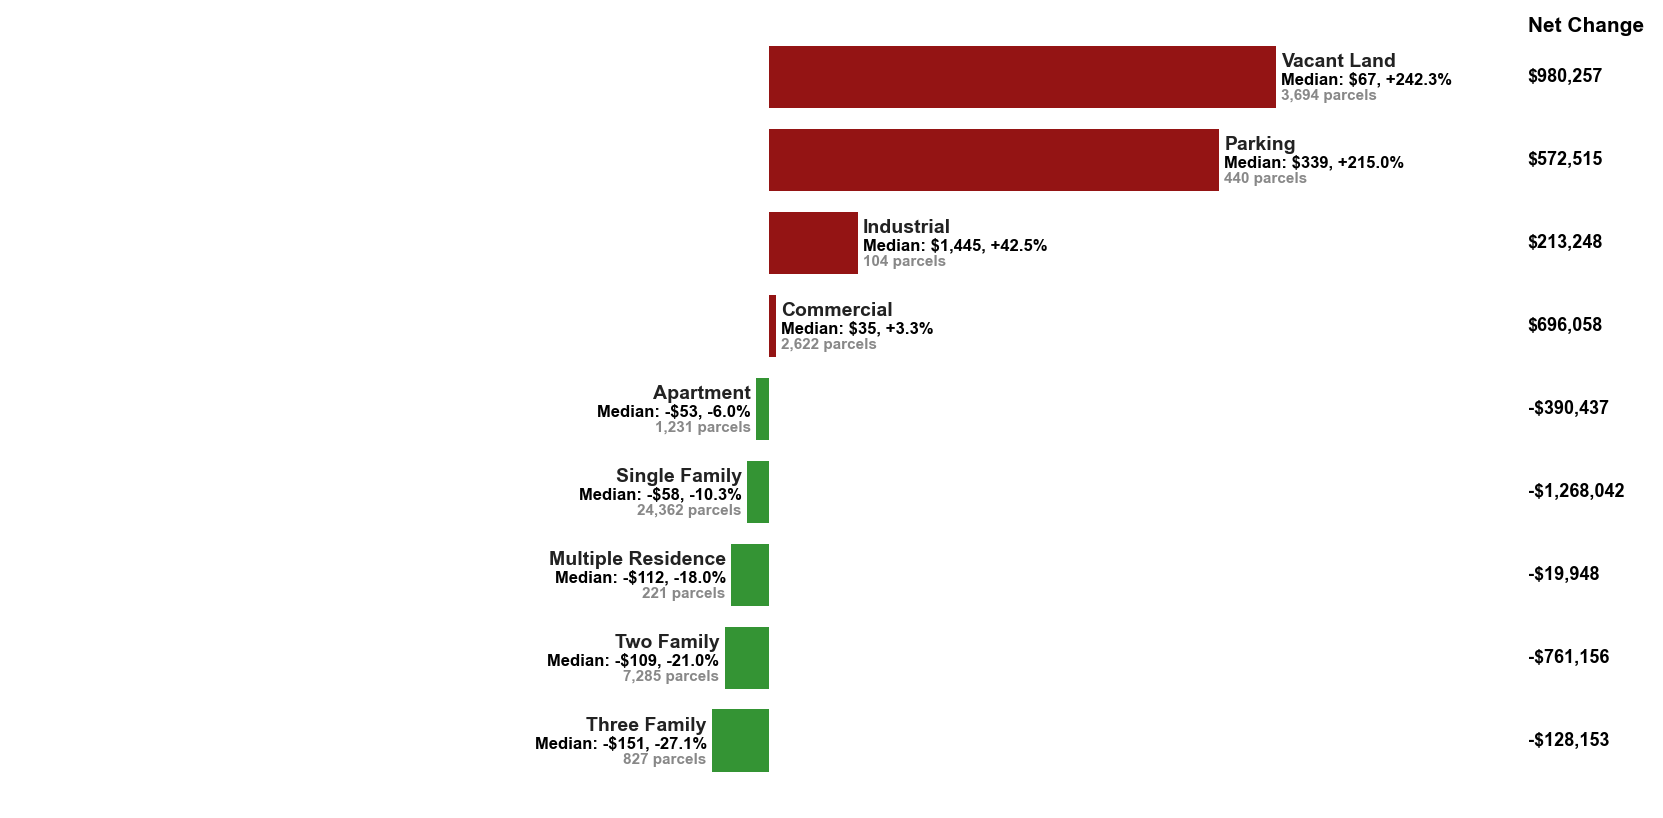

In [254]:
# Property category impact chart (Spokane style, sorted, ignore 0% median)
import matplotlib.pyplot as plt
import numpy as np

# Filter out categories where median tax change percent is exactly 0
filtered = category_summary[category_summary['median_tax_change_pct'] != 0].copy()

# Only include categories with property_count > 0 (optional, but safe)
filtered = filtered[filtered['property_count'] > 0]

# Sort by median_pct_change ascending (like Spokane)
categories = filtered['PROPERTY_CATEGORY'].tolist()
counts = filtered['property_count'].tolist()
median_pct_change = filtered['median_tax_change_pct'].tolist()
median_dollar_change = filtered['median_tax_change'].tolist()
total_tax_change = (
    filtered['total_tax_change_dollars'].tolist()
    if 'total_tax_change_dollars' in filtered.columns
    else (filtered['mean_tax_change'] * filtered['property_count']).tolist()
)

# Sort by median_pct_change ascending
sorted_idx = np.argsort(median_pct_change)
categories = [categories[i] for i in sorted_idx]
counts = [counts[i] for i in sorted_idx]
median_pct_change = [median_pct_change[i] for i in sorted_idx]
median_dollar_change = [median_dollar_change[i] for i in sorted_idx]
total_tax_change = [total_tax_change[i] for i in sorted_idx]

# Custom color: anything above 0 is dark red, below 0 is green
bar_colors = []
for val in median_pct_change:
    if val > 0:
        bar_colors.append("#8B0000")  # dark red
    else:
        bar_colors.append("#228B22")  # professional green

# Bar settings
bar_height = 0.75
fig_height = len(categories) * 0.8 + 1.2
right_col_pad = 120  # more padding for right column
fig, ax = plt.subplots(figsize=(17, fig_height))  # wider for right column

y = np.arange(len(categories))

# Draw bars
ax.barh(
    y, median_pct_change, color=bar_colors, edgecolor='none',
    height=bar_height, alpha=0.92, linewidth=0, zorder=2
)

# Remove all spines and ticks for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Adjusted vertical spacing
cat_offset = 0.18   # less space between category and median
med_offset = -0.03  # median just below category
count_offset = -0.23  # more space below median for parcels

# For right column: position for total tax change
max_abs = max(abs(min(median_pct_change)), abs(max(median_pct_change)))
right_col_x = max_abs + right_col_pad

# Add Net Change header at the top of the right column
ax.text(
    right_col_x, len(categories) - 0.5, "Net Change", va='bottom', ha='left',
    fontsize=15, fontweight='bold', color='black', fontname='Arial'
)

for i, (cat, val, count, med_dol, tot_change) in enumerate(zip(categories, median_pct_change, counts, median_dollar_change, total_tax_change)):
    # Format median dollar and percent change together
    if med_dol >= 0:
        med_dol_str = f"${med_dol:,.0f}"
    else:
        med_dol_str = f"-${abs(med_dol):,.0f}"
    pct_str = f"{val:+.1f}%"
    median_combo = f"Median: {med_dol_str}, {pct_str}"

    # Position: right of bar for positive, left for negative
    if val < 0:
        xpos = val - 2.5
        ha = 'right'
    else:
        xpos = val + 2.5
        ha = 'left'
    # Category name (bold, bigger)
    ax.text(
        xpos, y[i]+cat_offset, cat, va='center', ha=ha,
        fontsize=14, fontweight='bold', color='#222',
        fontname='Arial'
    )
    # Median (dollar + percent, bold, black, just below category)
    ax.text(
        xpos, y[i]+med_offset, median_combo, va='center', ha=ha,
        fontsize=12, fontweight='bold', color='black',
        fontname='Arial'
    )
    # Count (bold, smaller, below median)
    ax.text(
        xpos, y[i]+count_offset, f"{count:,} parcels", va='center', ha=ha,
        fontsize=11, fontweight='bold', color='#888',
        fontname='Arial'
    )
    # Net change column, always right-aligned in a new column, black text, no "Total:"
    if tot_change >= 0:
        tot_change_str = f"${tot_change:,.0f}"
    else:
        tot_change_str = f"-${abs(tot_change):,.0f}"
    ax.text(
        right_col_x, y[i], tot_change_str, va='center', ha='left',
        fontsize=13, fontweight='bold', color='black',
        fontname='Arial'
    )

# Set x limits for symmetry, make bars longer, and leave space for right column
ax.set_xlim(-right_col_x, right_col_x + 60)

# Remove axis labels/ticks
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.show()


# census

In [ ]:
# Get census data for Onondaga County, NY (Syracuse) - FIPS code: 36067
print("📊 Loading Census data for Onondaga County, NY...")
df  = gdf
try:
    census_data, census_boundaries = get_census_data_with_boundaries(
        fips_code="36067",  # Onondaga County, NY
        year=2022
    )
    print("GOT CENSUS DATA")
    # Set CRS for census boundaries before merging
    census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system
    
    # Ensure our parcel data is in the same CRS
    if df.crs != census_boundaries.crs:
        df = df.to_crs(census_boundaries.crs)
    
    # Merge census data with our parcel boundaries
    df = match_to_census_blockgroups(
        gdf=df,
        census_gdf=census_boundaries
    )
    
    print(f"✅ Census data integration complete!")
    print(f"Number of census block groups: {len(census_boundaries)}")
    print(f"Number of census data records: {len(census_data)}")
    print(f"Number of parcels with census data: {len(df)}")
    
    # Display new columns added
    census_cols = [col for col in df.columns if col in ['median_income', 'minority_pct', 'black_pct', 'total_pop', 'census_block_group']]
    print(f"Census columns added: {census_cols}")
    
except Exception as e:
    print(f"❌ Error loading census data: {e}")


📊 Loading Census data for Onondaga County, NY...
GOT CENSUS DATA
❌ Error loading census data: match_to_census_blockgroups() got an unexpected keyword argument 'parcels_gdf'


In [256]:
# Analyze tax impacts by income quintiles (similar to Spokane analysis)
print("📊 Analyzing tax impacts by neighborhood income quintiles...")

if 'median_income' in df.columns:
    # Filter out parcels with missing or non-positive income data
    df_with_income = df[(df['median_income'].notna()) & (df['median_income'] > 0)].copy()
    
    # Create income quintiles
    df_with_income['income_quintile'] = pd.qcut(
        df_with_income['median_income'], 
        5, 
        labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"]
    )
    
    # Calculate summary statistics by quintile
    quintile_summary = df_with_income.groupby('income_quintile').agg({
        'tax_change': ['count', 'mean', 'median'],
        'tax_change_pct': ['mean', 'median'],
        'median_income': 'mean',
        'current_tax': 'mean'
    }).round(2)
    
    # Flatten column names
    quintile_summary.columns = ['_'.join(col).strip() for col in quintile_summary.columns]
    quintile_summary = quintile_summary.reset_index()
    
    print(f"✅ Income quintile analysis complete")
    print(f"Parcels with income data: {len(df_with_income):,} ({len(df_with_income)/len(df)*100:.1f}%)")
    
    display(quintile_summary)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Median tax change percentage by income quintile
    quintile_data = quintile_summary.copy()
    quintile_data['median_tax_change_pct'] = quintile_data['tax_change_pct_median']
    
    bars1 = ax1.bar(
        quintile_data['income_quintile'],
        quintile_data['median_tax_change_pct'],
        color='steelblue',
        alpha=0.7
    )
    
    ax1.set_title('Median Tax Change % by Income Quintile', fontweight='bold', pad=20)
    ax1.set_ylabel('Median Tax Change (%)')
    ax1.set_xlabel('Income Quintile')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars1, quintile_data['median_tax_change_pct']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Average neighborhood income by quintile
    bars2 = ax2.bar(
        quintile_data['income_quintile'],
        quintile_data['median_income_mean'],
        color='green',
        alpha=0.7
    )
    
    ax2.set_title('Average Neighborhood Income by Quintile', fontweight='bold', pad=20)
    ax2.set_ylabel('Average Median Income ($)')
    ax2.set_xlabel('Income Quintile')
    ax2.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add value labels on bars
    for bar, val in zip(bars2, quintile_data['median_income_mean']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'${val:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Census income data not available - skipping quintile analysis")


📊 Analyzing tax impacts by neighborhood income quintiles...
❌ Census income data not available - skipping quintile analysis


In [257]:
# Scatter plot analysis: Income vs Tax Impact (similar to Spokane)
print("📈 Creating scatter plot analysis...")

if 'median_income' in df.columns and 'tax_change_pct' in df.columns:
    # Filter data for meaningful analysis
    plot_data = df[
        (df['median_income'].notna()) & 
        (df['median_income'] > 0) & 
        (df['tax_change_pct'].notna()) &
        (df['tax_change_pct'].abs() < 100)  # Remove extreme outliers
    ].copy()
    
    # Create block group level summary for cleaner visualization
    if 'census_block_group' in df.columns:
        block_summary = plot_data.groupby('census_block_group').agg({
            'median_income': 'first',  # Same for all parcels in block group
            'tax_change_pct': 'median',
            'tax_change': 'median',
            'current_tax': 'sum',
            'total_pop': 'first'
        }).reset_index()
        
        plot_data_agg = block_summary
        size_col = 'total_pop'
        title_suffix = "by Census Block Group"
    else:
        # Use individual parcels if no block group data
        plot_data_agg = plot_data.sample(min(1000, len(plot_data)))  # Sample for performance
        size_col = 'current_tax'
        title_suffix = "by Individual Parcels (Sample)"
    
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create scatter plot with size based on population or tax
    scatter = ax.scatter(
        plot_data_agg['median_income'],
        plot_data_agg['tax_change_pct'],
        s=plot_data_agg[size_col] / plot_data_agg[size_col].max() * 200 + 20,
        alpha=0.6,
        c=plot_data_agg['tax_change_pct'],
        cmap='RdYlBu_r',
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add trend line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        plot_data_agg['median_income'], 
        plot_data_agg['tax_change_pct']
    )
    line_x = np.array([plot_data_agg['median_income'].min(), plot_data_agg['median_income'].max()])
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2, 
            label=f'Trend (R² = {r_value**2:.3f})')
    
    # Formatting
    ax.set_xlabel('Neighborhood Median Income ($)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Median Tax Change (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Tax Impact vs. Neighborhood Income {title_suffix}', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Format x-axis as currency
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Tax Change (%)', fontweight='bold')
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation statistics
    correlation = plot_data_agg['median_income'].corr(plot_data_agg['tax_change_pct'])
    print(f"\\n📊 Correlation Analysis:")
    print(f"- Correlation coefficient: {correlation:.3f}")
    print(f"- R-squared: {r_value**2:.3f}")
    print(f"- P-value: {p_value:.3e}")
    print(f"- Sample size: {len(plot_data_agg):,} observations")
    
    if correlation > 0:
        print("📈 Positive correlation: Higher income areas tend to have higher tax increases")
    elif correlation < 0:
        print("📉 Negative correlation: Higher income areas tend to have lower tax increases")
    else:
        print("➡️  No clear correlation between income and tax changes")
        
else:
    print("❌ Required data not available for scatter plot analysis")


📈 Creating scatter plot analysis...
❌ Required data not available for scatter plot analysis


In [258]:
# Final Summary Analysis
print("📋 SYRACUSE LVT POLICY ANALYSIS SUMMARY")
print("=" * 60)

# Overall tax impact summary
total_parcels = len(df)
total_current_tax = df['current_tax'].sum()
total_tax_change = df['tax_change'].sum()
total_new_tax = total_current_tax + total_tax_change

print(f"\\n🏠 OVERALL IMPACT:")
print(f"- Total parcels analyzed: {total_parcels:,}")
print(f"- Current total tax revenue: ${total_current_tax:,.2f}")
print(f"- Total tax change: ${total_tax_change:,.2f}")
print(f"- New total tax revenue: ${total_new_tax:,.2f}")
print(f"- Net change: {(total_tax_change/total_current_tax)*100:+.2f}%")

# Winners and losers
tax_increases = (df['tax_change'] > 0).sum()
tax_decreases = (df['tax_change'] < 0).sum()
no_change = (df['tax_change'] == 0).sum()

print(f"\\n📊 DISTRIBUTION OF IMPACTS:")
print(f"- Properties with tax increases: {tax_increases:,} ({tax_increases/total_parcels*100:.1f}%)")
print(f"- Properties with tax decreases: {tax_decreases:,} ({tax_decreases/total_parcels*100:.1f}%)")
print(f"- Properties with no change: {no_change:,} ({no_change/total_parcels*100:.1f}%)")

# Median impacts
median_tax_change = df['tax_change'].median()
median_tax_change_pct = df['tax_change_pct'].median()

print(f"\\n📈 TYPICAL IMPACTS:")
print(f"- Median tax change: ${median_tax_change:.2f}")
print(f"- Median tax change percentage: {median_tax_change_pct:.2f}%")

# Census-based equity analysis (if available)
if 'median_income' in df.columns:
    print(f"\\n🏘️  EQUITY ANALYSIS:")
    
    # Low vs high income areas
    df_with_income = df[(df['median_income'].notna()) & (df['median_income'] > 0)]
    low_income_threshold = df_with_income['median_income'].quantile(0.33)
    high_income_threshold = df_with_income['median_income'].quantile(0.67)
    
    low_income_parcels = df_with_income[df_with_income['median_income'] <= low_income_threshold]
    high_income_parcels = df_with_income[df_with_income['median_income'] >= high_income_threshold]
    
    low_income_median_change = low_income_parcels['tax_change_pct'].median()
    high_income_median_change = high_income_parcels['tax_change_pct'].median()
    
    print(f"- Low-income areas (bottom 33%): {low_income_median_change:.2f}% median tax change")
    print(f"- High-income areas (top 33%): {high_income_median_change:.2f}% median tax change")
    
    if low_income_median_change < high_income_median_change:
        print("  → Policy appears progressive (lower burden on low-income areas)")
    elif low_income_median_change > high_income_median_change:
        print("  → Policy appears regressive (higher burden on low-income areas)")
    else:
        print("  → Policy appears neutral across income levels")

# Property type analysis summary
if category_col in df.columns:
    print(f"\\n🏢 PROPERTY TYPE IMPACTS:")
    
    # Find the categories with biggest increases and decreases
    cat_summary = df.groupby(category_col)['tax_change'].agg(['sum', 'median', 'count']).round(2)
    cat_summary = cat_summary.sort_values('sum', ascending=False)
    
    print("Top 3 categories by total tax increase:")
    for i, (cat, row) in enumerate(cat_summary.head(3).iterrows()):
        print(f"  {i+1}. {cat}: ${row['sum']:,.0f} total, ${row['median']:.0f} median ({row['count']:,} properties)")
    
    print("\\nTop 3 categories by total tax decrease:")
    for i, (cat, row) in enumerate(cat_summary.tail(3).iterrows()):
        print(f"  {i+1}. {cat}: ${row['sum']:,.0f} total, ${row['median']:.0f} median ({row['count']:,} properties)")

print(f"\\n" + "=" * 60)
print("📝 NOTES:")
print("- This analysis uses sample/placeholder tax change data for demonstration")
print("- Replace the tax change calculations with your actual LVT policy model")
print("- Census data integration provides demographic context for equity analysis")
print("- Visualizations above show the distributional impacts across income and property types")

print(f"\\n✅ Analysis complete! Review the visualizations above for detailed insights.")


📋 SYRACUSE LVT POLICY ANALYSIS SUMMARY
\n🏠 OVERALL IMPACT:
- Total parcels analyzed: 41,697
- Current total tax revenue: $31,644,825.77
- Total tax change: $-0.00
- New total tax revenue: $31,644,825.77
- Net change: -0.00%
\n📊 DISTRIBUTION OF IMPACTS:
- Properties with tax increases: 14,099 (33.8%)
- Properties with tax decreases: 25,620 (61.4%)
- Properties with no change: 1,978 (4.7%)
\n📈 TYPICAL IMPACTS:
- Median tax change: $-47.49
- Median tax change percentage: -8.56%


NameError: name 'category_col' is not defined